##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title License header
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ResNet

[ResNet](https://arxiv.org/abs/1512.03385) is a deep neural network architecture for image recognition.

This notebook

* Constructs a [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50) model using `tf.keras`, with weights pretrained using the[ImageNet](http://www.image-net.org/) dataset
* Compiles that model with IREE
* Tests TensorFlow and IREE execution of the model on a sample image

In [1]:
#@title Imports and common setup

from pyiree import rt as ireert
from pyiree.tf import compiler as ireec
from pyiree.tf.support import tf_utils

import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
#@title Construct a pretrained ResNet model with ImageNet weights

# Static shape, including batch size (1).
# Can be dynamic once dynamic shape support is ready.
INPUT_SHAPE = [1, 224, 224, 3]

tf_model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet", include_top=True, input_shape=tuple(INPUT_SHAPE[1:]))

# Wrap the model in a tf.Module to compile it with IREE.
class ResNetModule(tf.Module):

  def __init__(self):
    super(ResNetModule, self).__init__()
    self.m = tf_model
    self.m.predict = lambda x: self.m.call(x, training=False)
    self.predict = tf.function(
        input_signature=[tf.TensorSpec(INPUT_SHAPE, tf.float32)])(tf_model.predict)

In [3]:
#@markdown ### Backend Configuration

backend_choice = "iree_vmla (CPU)" #@param [ "iree_vmla (CPU)", "iree_llvmjit (CPU)", "iree_vulkan (GPU/SwiftShader)" ]
backend_choice = backend_choice.split(" ")[0]
backend = tf_utils.BackendInfo(backend_choice)

In [4]:
#@title Compile ResNet with IREE
# This may take a few minutes.
iree_module = backend.compile(ResNetModule, ["predict"])

Created IREE driver vmla: <iree.bindings.python.pyiree.rt.binding.HalDriver object at 0x7fef48c98298>
SystemContext driver=<iree.bindings.python.pyiree.rt.binding.HalDriver object at 0x7fef48c98298>


Test image:


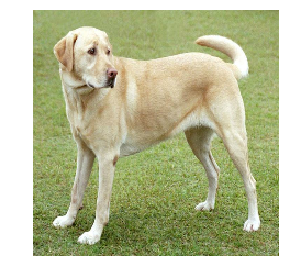

In [7]:
#@title Load a test image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)

def load_image(path_to_image):
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.resize(image, (224, 224))
  image = image[tf.newaxis, :]
  return image

content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_image(content_path)

print("Test image:")
plt.imshow(content_image.numpy().reshape(224, 224, 3) / 255.0)
plt.axis("off")
plt.tight_layout()

In [8]:
#@title Model pre- and post-processing
input_data = tf.keras.applications.resnet50.preprocess_input(content_image)

def decode_result(result):
  return tf.keras.applications.resnet50.decode_predictions(result, top=3)[0]

In [9]:
#@title Run TF model

print("TF prediction:")
tf_result = tf_model.predict(input_data)
print(decode_result(tf_result))

TF prediction:
[('n02091244', 'Ibizan_hound', 0.12879108), ('n02099712', 'Labrador_retriever', 0.12632962), ('n02091831', 'Saluki', 0.09625229)]


In [10]:
#@title Run the model compiled with IREE

print("IREE prediction:")
iree_result = iree_module.predict(input_data)
print(decode_result(iree_result))

IREE prediction:
[('n02091244', 'Ibizan_hound', 0.12879075), ('n02099712', 'Labrador_retriever', 0.1263297), ('n02091831', 'Saluki', 0.09625255)]
